# Integration tests for interleaved filter/smoother

[Durbin and Koopman (2000)](http://onlinelibrary.wiley.com/doi/10.1111/1467-9892.00186/abstract) and Durbin and Koopman (2012) section 6.4 showed that a method of interleaving vector observations to create a univariate series avoided matrix inversion and resulted in a large computational speedup.

**Important**: This method assumes that $\varepsilon_t \sim \mathcal{N}(0, H_t)$ with $H_t$ diagonal!

In [1]:
using Distributions
using PyPlot
plt.style[:use]("ggplot")

srand(12347) # set random seed

INFO: Loading help data...


# Generate data from a state space model

**Note**: Observation noise is deliberately set low here so that recovered states line up *exactly* below (i.e., it's a sanity check).

In [2]:
Zk = [1 -1. ; 0 1 ; 1 0]  # observation matrix
Hk = 50 * [1 0 0 ; 0 1.2 0 ; 0 0 1.5]

Np, Nm = size(Zk)

th = 10 * pi / 180  # rotation angle
Tk = [cos(th) sin(th) ; -sin(th) cos(th)]
Rk = reshape([1.1 1], 2, 1)
Qk = reshape([0.25], 1, 1)

Nr = size(Rk, 2)

a_init = zeros(Nm)
P_init = 5 * eye(Nm)


2x2 Array{Float64,2}:
 5.0  0.0
 0.0  5.0

## Now generate some data

In [3]:
Nt = 100  # number of samples
Z = Array(Float64, size(Zk)..., Nt)
T = Array(Float64, size(Tk)..., Nt)
H = Array(Float64, size(Hk)..., Nt)
R = Array(Float64, size(Rk)..., Nt)
Q = Array(Float64, size(Qk)..., Nt)
for t in 1:Nt
    Z[:, :, t] = Zk
    T[:, :, t] = Tk + 0.05 * rand()
    H[:, :, t] = (1 + 0.05 * rand()) * Hk
    R[:, :, t] = (1 + 0.05 * rand()) * Rk
    Q[:, :, t] = (1 + 0.15 * rand()) * Qk
end

In [4]:
# preallocate data arrays
α = Array(Float64, Nm, Nt)
y = Array(Float64, Np, Nt)
ϵ = Array(Float64, Np, Nt)
η = Array(Float64, Nr, Nt)

1x100 Array{Float64,2}:
 6.93616e-310  6.9362e-310  6.93619e-310  …  6.93619e-310  9.88131e-324

In [5]:
# initialize

α[:, 1] = rand(MvNormal(a_init, P_init))

for t in 1:Nt
    Z_t = Z[:, :, t]
    T_t = T[:, :, t]
    H_t = H[:, :, t]
    R_t = R[:, :, t]
    Q_t = Q[:, :, t]
    ϵ[:, t] = rand(MvNormal(H_t))
    η[:, t] = rand(MvNormal(Q_t))
    y[:, t] = Z_t * α[:, t] + ϵ[:, t]
    if t < Nt
        α[:, t + 1] = T_t * α[:, t] + R_t * η[:, t]
    end
end

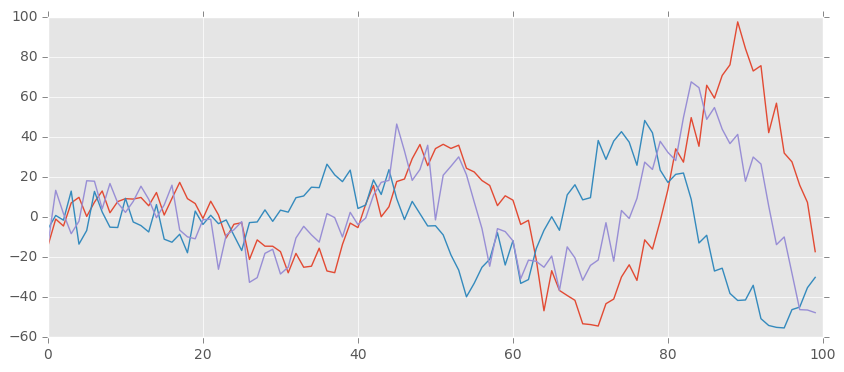

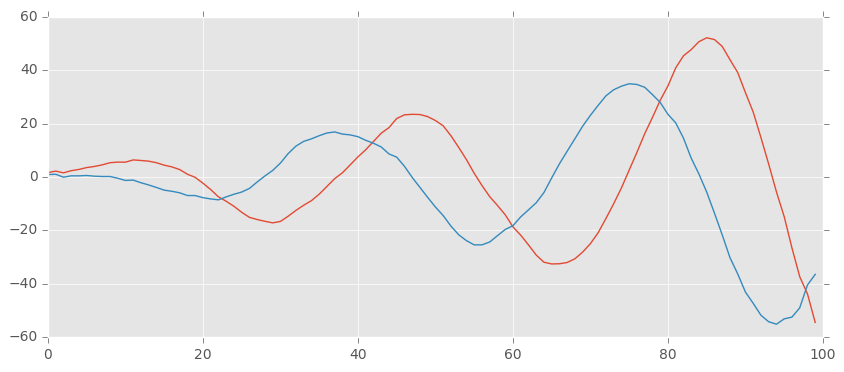

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1195d6210>
 PyObject <matplotlib.lines.Line2D object at 0x1195d6490>

In [6]:
figure(figsize=(10, 4))
plot(y')

figure(figsize=(10, 4))
plot(α')

# Kalman filter

In [7]:
import SStools

In [8]:
v, K, Finv, a2, P = SStools.kalman_filter(y, a_init, P_init, Z, H, T, R, Q);

In [9]:
v, K, Finv, a, P = SStools.interleaved_kalman_filter(y, a_init, P_init, Z, H, T, R, Q);

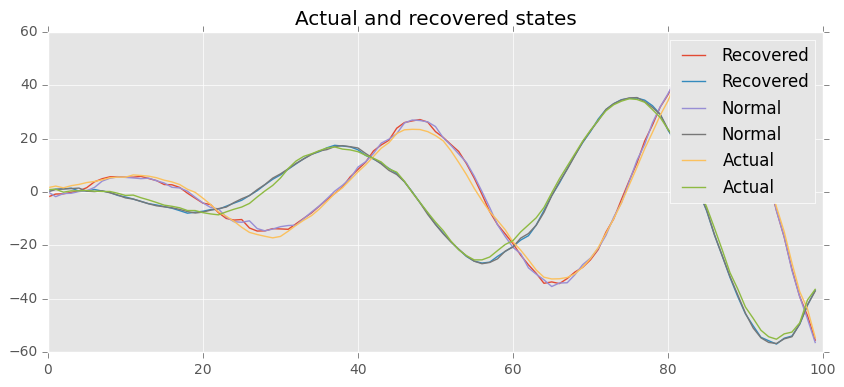

PyObject <matplotlib.legend.Legend object at 0x115c5fe90>

In [10]:
figure(figsize=(10, 4))
plot(squeeze(a[:, end, :], 2)', label="Recovered")
plot(a2', label="Normal")
plot(α', label="Actual")
title("Actual and recovered states")
legend()

#Smoother

In [11]:
ahat = SStools.interleaved_state_smoother(v, K, Finv, a_init, P_init, Z, T, R, Q);

In [12]:
v, K, Finv, a, P = SStools.kalman_filter(y, a_init, P_init, Z, H, T, R, Q);
ahat2 = SStools.fast_state_smoother(v, K, Finv, a_init, P_init, Z, T, R, Q);

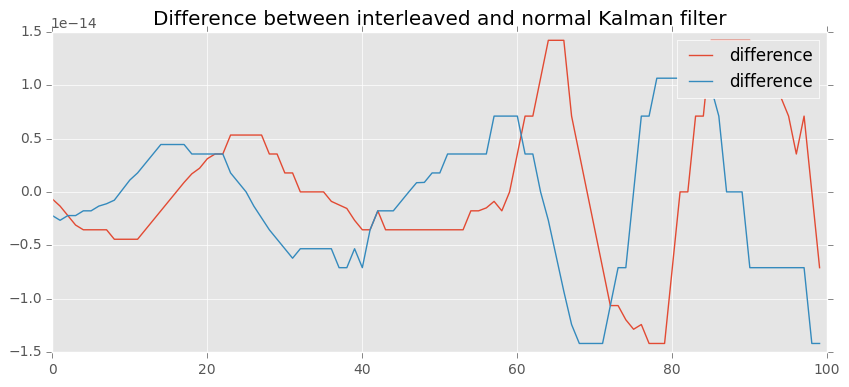

PyObject <matplotlib.legend.Legend object at 0x11ab6e050>

In [18]:
figure(figsize=(10, 4))
plot(ahat' - ahat2', label="difference")
title("Difference between interleaved and normal Kalman filter")
legend()

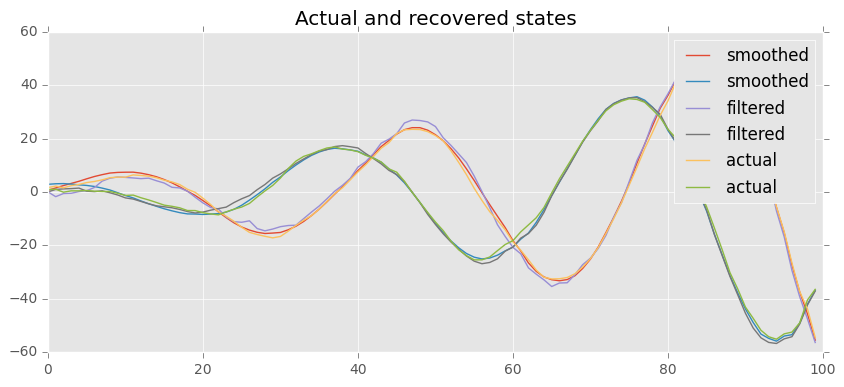

PyObject <matplotlib.legend.Legend object at 0x11a2f7190>

In [14]:
figure(figsize=(10, 4))
plot(ahat', label="smoothed")
plot(a', label="filtered")
plot(α', label="actual")
title("Actual and recovered states")
legend()